# Sentiment classification task
* [Class Video](https://youtu.be/gbceqO8PpBg?t=1h31m11s)
* [Class Notes](https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-4-2048a26d58aa)
* [Notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson4-imdb.ipynb)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
t0 = time.clock()
time.ctime(time.time())

In [ ]:
import torch
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

#from fastai.learner import *
#from fastai.rnn_reg import *
#from fastai.rnn_train import *
#from fastai.nlp import *
#from fastai.lm_rnn import *

import dill as pickle

# Language modeling

## Data

The [large movie view dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50K reviews from IMDB. 
The dataset contains an even number of positive and negative reviews. 
The authors considered only highly polarized reviews. 
A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. 
Neutral reviews are not included in the dataset. 
The dataset is divided into training and test sets. 
The training set is the same 25K labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

However, before we try to classify *sentiment*, we will simply try to create a *language model*; 
that is, a model that can predict the next word in a sentence. 
*Why?* Because our model first needs to understand the structure of English, before we can expect it to recognize positive vs negative sentiment.

So our plan of attack is the same as we used for Dogs v Cats: pretrain a model to do one thing (here to predict the next word), and fine tune it to do something else (classify sentiment).<br>
Unfortunately, there are no good pretrained language models available to download, so we need to create our own. 
To follow along, download the [dataset](http://files.fast.ai/data/aclImdb.tgz).

In [52]:
from pathlib import Path
PATH = Path('/data/aclImdb/')
list(PATH.iterdir())

[PosixPath('/data/aclImdb/imdb.vocab'),
 PosixPath('/data/aclImdb/README'),
 PosixPath('/data/aclImdb/.DS_Store'),
 PosixPath('/data/aclImdb/imdbEr.txt'),
 PosixPath('/data/aclImdb/train'),
 PosixPath('/data/aclImdb/test')]

In [54]:
TRN = PATH/'train/all'
VAL = PATH/'test/all'
TRN, VAL

(PosixPath('/data/aclImdb/train/all'), PosixPath('/data/aclImdb/test/all'))

PATH='/data/aclImdb/'

TRN_PATH = 'train/all/'
VAL_PATH = 'test/all/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

Let's look inside the training folder... 

In [61]:
trn_files = list(TRN.iterdir())
trn_files[0]

PosixPath('/data/aclImdb/train/all/35487_0.txt')

trn_files = !ls {TRN}
trn_files[:5]

...and at an example review.

In [62]:
review = !cat {trn_files[6]}
review[0]

"I think worst movie ever is being too kind. If I had the option of watching this again or ramming nails through my head, I would choose the latter and I hope all of you do as well. This has got to be the dumbest idea I have ever heard of. And Hulk Hogan? Wow, he is just absolutely pathetic. Stick to wrestling - that's something you suck at slightly less than acting."

Now we'll check how many words are in the training and test datasets.

In [66]:
trnw = !find {TRN} -name '*.txt' | xargs cat | wc -w
testw = !find {VAL} -name '*.txt' | xargs cat | wc -w
trw, testw

(['17486581'], ['5686719'])

### Tokenize 
Before we can analyze text, we must first *tokenize* it. This refers to the process of splitting a sentence into an array of words (or more generally, into an array of *tokens*).
A good tokenizer will do a good job of recognizing pieces in your sentence. 
Each separated piece of punctuation will be separated, and each part of multi-part word will be separated as appropriate. 
`Spacy` currently has the best tokenizer. 

In [67]:
import spacy 

In [68]:
spacy_tok = spacy.load('en')
' '.join([sent.string.strip() for sent in spacy_tok(review[0])])

"I think worst movie ever is being too kind . If I had the option of watching this again or ramming nails through my head , I would choose the latter and I hope all of you do as well . This has got to be the dumbest idea I have ever heard of . And Hulk Hogan ? Wow , he is just absolutely pathetic . Stick to wrestling - that 's something you suck at slightly less than acting ."

We use Pytorch's [torchtext](https://github.com/pytorch/text) library to preprocess our data, telling it to use [spacy](https://spacy.io/) library to handle tokenization.

First, we create a torchtext *field*, which describes how to preprocess a piece of text - in this case, we tell torchtext to make everything lowercase, and tokenize it with spacy.

In [8]:
#?data.Field

In [69]:
TEXT = data.Field(lower=True, tokenize="spacy")   

## LanguageModelData
fastai works(ed?) with torchtext. We create a ModelData object for LM by taking advantage of `LanguageModelData`.
We don't have a separate test set, so we'll just use `VAL_PATH` for that too.

`Parameters:`
- `PATH` is the "root" directory.
- `TEXT` is the torchtext field object.
- `FILES` contains the paths to the training, test, and validation sets. (Here we don't have a separate test set, so we'll just use `VAL_PATH` for that too.)
- `bs` is the (usual) batch size parameter. 
- `bptt` (Back-Prop-Thru-Time) break up sentences for the GPU, i.e., defines how many words are processed at a time in each mini-batch row. *More importantly, it defines how many 'layers' we will backprop through.* Making this number higher will increase time and memory requirements, but will improve the model's ability to handle long sentences.
- `min_freq` gives the minimum number of times a word occurs before it is defined as unknown.

In [70]:
bs=34    #64 was too big?
bptt=54 #52  #70was too big for the DL GPU# 
min_freq=10

The `dict()` constructor builds dictionaries directly from sequences of key-value pairs:

In [71]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)

In [47]:
from fastai.nlp import LanguageModelData

In [72]:
#This takes approx (was 14) 4 minutes 
%time md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=min_freq)

CPU times: user 4min 4s, sys: 3.07 s, total: 4min 7s
Wall time: 4min 7s


After building our `ModelData` object, it automatically fills the `TEXT` object with attribute: `TEXT.vocab`. 
This is a *vocabulary*, which stores which words (or *tokens*) have been seen in the text, 
and how each word will be mapped to a unique integer id. 
We'll need to use this information again later, so we save it.

*(Technical note: python's standard `Pickle` library can't handle this correctly, so we used the `dill` library instead and imported it as `pickle`)*.

In [51]:
PATH

'/data/aclImdb/'

Below commented out as it gives
```
ATtributeError: Can't pickle local object 'get_tokenizer.<locals>.<lambda>'
```

In [74]:
(PATH/'models').mkdir(exist_ok=True)
pickle.dump(TEXT, open(f'{PATH}/models/TEXT.pkl','wb'))   # Save the vocabulary

AttributeError: Can't pickle local object 'get_tokenizer.<locals>.<lambda>'

Here are the: # batches; # unique tokens in the vocab; # tokens in the training set; # sentences

In [75]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(11186, 37392, 1, 20540756)

This is our embedding matrix looks like:
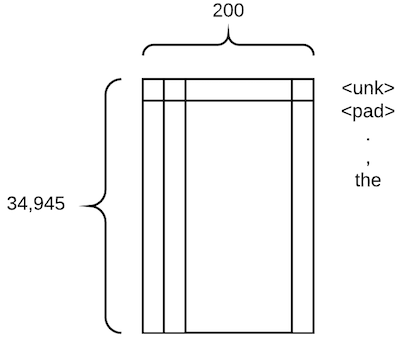

It is a high cardinality categorical variable and furthermore, it is the only variable — this is typical in NLP
The embedding size is 200 which is much bigger than our previous embedding vectors. 
Not surprising because a word has a lot more nuance to it than the concept of Sunday. 
Generally, an embedding size for a word will be somewhere between 50 and 600.

This is the start of the mapping from integer IDs to unique tokens. `itos`: 'int-to-string', `stoi`: 'string to int'

In [76]:
print(TEXT.vocab.itos[:8], "\n", TEXT.vocab.stoi['the'])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of'] 
 2


Note that in a `LanguageModelData` object there is only one item in each dataset: all the words of the text joined together.

In [77]:
md.trn_ds[0].text[:8]

['i', 'also', 'saw', 'this', 'movie', 'at', 'a', 'film']

torchtext will handle turning this words into integer IDs for us automatically.

In [78]:
TEXT.numericalize([md.trn_ds[0].text[:8]])

tensor([[  12],
        [ 100],
        [ 230],
        [  13],
        [  23],
        [  40],
        [   6],
        [  25]], device='cuda:0')

`LanguageModelData` object will create batches with `bs` columns, and varying sequence lengths of around (52?) tokens (that's our `bptt` parameter - *backprop through time*).   
Pytorch has a neat trick in which it randomly changes the bptt parameter, in each epoch, so each epoch gets a slightly different text.

Each batch also contains the exact same data as labels, but one word later in the text - since we're trying to always predict the next word. The labels are flattened into a 1d array.

In [79]:
next(iter(md.trn_dl))

(tensor([[    12,    317,      0,  ...,      8,     90,  13735],
         [   100,   9489,   2004,  ...,     79,     55,      3],
         [   230,      9,   3478,  ...,      2,    132,     43],
         ...,
         [     5,    317,      0,  ...,     29,    531,  14733],
         [    12,   9489,     30,  ...,    131,     22,     21],
         [   494,      8,     50,  ...,     11,  26591,     34]], device='cuda:0'),
 tensor([   100,   9489,   2004,  ...,      3,      2,   1649], device='cuda:0'))

# Train

We have a number of parameters to set - we'll learn more about these later, but you should find these values suitable for many problems.

In [80]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

Researchers have found that large amounts of *momentum* (which we'll learn about later) don't work well with these kinds of *RNN* models, so we create a version of the *Adam* optimizer with less momentum than it's default of `0.9`.
**NB: Per JH, the line below probably should be included on all NLP projects. **

In [81]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

fastai uses a variant of [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182) developed by Stephen Merity,
which provides excellent regularization through [Dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout). 
There is no simple way known (yet!) to find the best values of the dropout parameters below - just have to experiment...
<br>
However, the other parameters (`alpha`, `beta`, and `clip`) shouldn't generally need tuning.
`learner.clip` is a great trick to prevent gradients from exploding.
<br>
Here we learn what the architecture is and what all these dropouts are. 
For now, just know it is the same as per usual, if we try to build an NLP model and are:
* under-fitting, then decrease all these dropouts, 
* if overfitting, then increase all these dropouts in roughly this ratio. 

There is not yet much guidance but these ratios worked well — it is what Stephen has been using as well.
<br>
There is another way to avoid overfitting that we will review later. For now, 
```
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1) 
```
works reliably so all of your NLP models probably want this particular line.
<br>
`learner.clip=0.3` : when you look at your gradients and you multiply them by the learning rate to decide how much to update your weights by, this will not allow them be more than 0.3. 
A cool trick to prevent us from taking too big of a step.
Details do not matter too much right now, so you can use them as they are.

In [82]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

JH gradually tuned the language model in a few stages. He could have trained it further (it wasn't yet overfitting), but didn't have time to experiment more. Maybe we can train it to a better accuracy! 
(JH used `lr_find` to find a good learning rate (`3e-3`), but didn't save the output here.) 

### Find learn rate

In [83]:
%time learner.lr_find()

 71%|███████▏  | 7985/11186 [07:15<02:54, 18.32it/s, loss=19.4]CPU times: user 5min 47s, sys: 1min 30s, total: 7min 18s
Wall time: 7min 16s


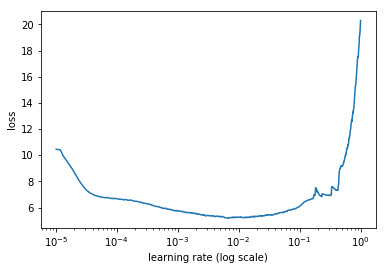

In [23]:
learner.sched.plot(10)  #100

Below may take 3 hours...

In [84]:
%time learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      4.783507   4.687582  
    1      4.667447   4.562921                                  
    2      4.568714   4.470159                                  
    3      4.647948   4.538742                                  
    4      4.596009   4.462342                                  
    5      4.49588    4.395629                                  
    6      4.457113   4.375185                                  
    7      4.602273   4.50309                                   
    8      4.575432   4.476228                                  
    9      4.537091   4.445274                                  
    10     4.484465   4.405921                                  
    11     4.476992   4.371138                                  
    12     4.432291   4.338491                                  
    13     4.374616   4.32078                                   
    14     4.35997    4.317215                           

[4.31721468091258]

In the sentiment analysis section, we'll just need half of the language model - the encoder, so we save that part.

In [85]:
learner.save_encoder('adam1_enc')

In [86]:
learner.load_encoder('adam1_enc')

In [27]:
#%time learner.load_cycle('adam3_10',2)

In [87]:
%time learner.fit(3e-3, 1, wds=1e-6, cycle_len=10)    # This may take 2 hours to complete

epoch      trn_loss   val_loss                                  
    0      4.602337   4.473054  
    1      4.589002   4.458205                                  
    2      4.5473     4.435968                                  
    3      4.506088   4.40824                                   
    4      4.478971   4.381382                                  
    5      4.420331   4.352043                                  
    6      4.382021   4.324463                                  
    7      4.376264   4.305068                                  
    8      4.36397    4.294311                                  
    9      4.380076   4.29208                                   
CPU times: user 1h 30min 3s, sys: 23min 42s, total: 1h 53min 46s
Wall time: 1h 53min 17s


[4.292079893467809]

In [88]:
learner.save_encoder('adam3_10_enc')

In the sentiment analysis section, we'll just need half of the language model - the *encoder*, so we save that part.

In [89]:
learner.save_encoder('adam3_20_enc')

In [90]:
learner.load_encoder('adam3_20_enc')

Language modeling accuracy is generally measured using the metric *perplexity*, which is simply `exp()` of the loss function we used.

In [91]:
math.exp(4.278112)

72.10417872771527

In [92]:
%time learner.fit(3e-3, 1, wds=1e-6, cycle_len=1)    # Keep going?

epoch      trn_loss   val_loss                                  
    0      4.461873   4.324393  
CPU times: user 8min 59s, sys: 2min 22s, total: 11min 22s
Wall time: 11min 19s


[4.324392980639722]

In [115]:
pickle.dump(TEXT, open(f'{PATH}/models/TEXT.pkl','wb'))

AttributeError: Can't pickle local object 'get_tokenizer.<locals>.<lambda>'

### Test

We can play with the LM to check if it works OK. 
First, let's create a short bit of text to 'prime' a set of predictions. 
We'll use our torchtext field to numericalize it so we can feed it to our language model.

In [123]:
m=learner.model
ss=""". So, it wasn't quite was I was expecting, but I really liked it anyway! The best"""
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
''.join(str(s[0]))
#type(str(s[0]))

". So, it wasn't quite was I was expecting, but I really liked it anyway! The best"

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [124]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [127]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['<unk>', ',', ')', '.', '!', "'", '...', '/><br', '"', '-']

...and let's see if our model can generate a bit more text all by itself!

In [151]:
n=res[-1].topk(2)[1]
#n = n[1] if n.data[0]==0 else n[0]
n.shape
n.data[0]
n.data[1]

tensor(3, device='cuda:0')

In [153]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    #n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

. So, it wasn't quite was I was expecting, but I really liked it anyway! The best 

<unk> 

ValueError: not enough values to unpack (expected 2, got 1)

### Sentiment

So we had pre-trained a LM and now we want to fine-tune it to do sentiment classification.
To use a pre-trained model, we need the saved `vocab` from the LM, 
to ensure the same words map to the same IDs.

In [99]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/data/aclImdbmodels/TEXT.pkl'

`sequential=False` tells torchtext that a text field should be tokenized (in this case, we just want to store the 'positive' or 'negative' single label).

`splits` is a torchtext method that creates train, test, and validation sets. The IMDB dataset is built into torchtext, so we can take advantage of that. Take a look at `lang_model-arxiv.ipynb` to see how to define your own fastai/torchtext datasets.

In [100]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')

downloading aclImdb_v1.tar.gz


In [101]:
t = splits[0].examples[0]

In [102]:
t.label, ' '.join(t.text[:16])

('pos',
 'the story is about ankush ( abhay deol ) - who is professional marriage witness ,')

fastai can create a ModelData object directly from torchtext splits. (Per JH)

In [103]:
#??TextData.from_splits
#??get_rnn_classifier

In [104]:
%time md2 = TextData.from_splits(PATH, splits, bs)

CPU times: user 92.1 ms, sys: 0 ns, total: 92.1 ms
Wall time: 91.6 ms


In [105]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_20_enc')

Because we're fine-tuning a pretrained model, we'll use differential learning rates, and also increase the max gradient for clipping, to allow the SGDR to work better.

In [106]:
??get_rnn_classifer

In [110]:
m3.clip=25.
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2]) # [1e-4,1e-3,1e-2])

In [111]:
from fastai.lm_rnn import *
from fastai.learner import *

In [112]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

epoch      trn_loss   val_loss   accuracy   
    0      0.630279   0.334468   0.862404  


/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torcht

epoch      trn_loss   val_loss   accuracy   
    0      0.412209   0.283636   0.889523  


[0.28363643448392367, 0.8895233568905405]

We make sure all except the last layer is frozen. Then we train a bit, unfreeze it, train it a bit. The nice thing is once you have got a pre-trained language model, it actually trains really fast.

In [ ]:
%time m3.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

In [ ]:
m3.load_cycle('imdb2', 4)

In [ ]:
accuracy_np(*m3.predict_with_targs())   #was just accuracy but redefined for the right argument type.

## Compare with other results

A recent paper from Bradbury et al, [Learned in translation: contextualized word vectors](https://einstein.ai/research/learned-in-translation-contextualized-word-vectors), has a summary of academic research for the IMDB sentiment analysis problem. 
Many of the latest algorithms shown are tuned for this specific problem.

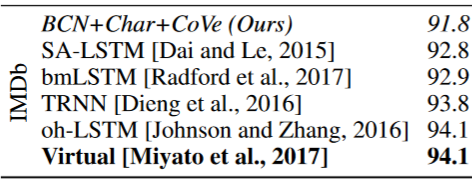

We got a better result in sentiment analysis, decreasing the error from 5.9% to 5.5%! 
You should be able to get similarly world-class results on other NLP classification problems 
using the same basic steps.

There are many opportunities to further improve this, although we won't be able to get to them until part 2 of this course...

# End

In [ ]:
t1 = time.clock()
time.ctime(time.time()), (t1 - t0)